In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from mpl_toolkits import mplot3d

from scipy.misc import derivative
from scipy import integrate

sns.set(rc={'figure.figsize': (12, 8)})

In [2]:
def plt_3d(X, Y, Z, labels):
    x_label, y_label, z_label = labels
    ax = plt.axes(projection='3d')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.plot_surface(X, Y, Z)
    return ax

def lineplot(x, y, labels):
    x_label, y_label = labels
    ax = sns.lineplot(x, y)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    return ax

### Bounded pareto distribution

First we implemented a bounded pareto density distribution as:

\begin{align}
    f(x) = \frac{\alpha \cdot L^{\alpha} \cdot x^{-(\alpha+1)}}{1 - \left(\frac{L}{H}\right)^{\alpha}}
\end{align}

note that in our case $H \xrightarrow{} \infty$ hence $f(x) = \alpha \cdot L^{\alpha} \cdot x^{-(\alpha+1)}$

In [3]:
from utils.distribution import BoundedParetoDensity

In [20]:
dens = BoundedParetoDensity(alpha=3, L=2)

expected_value = dens.E
print("Truncated density expected value: ", expected_value) 

Truncated density expected value:  3.0


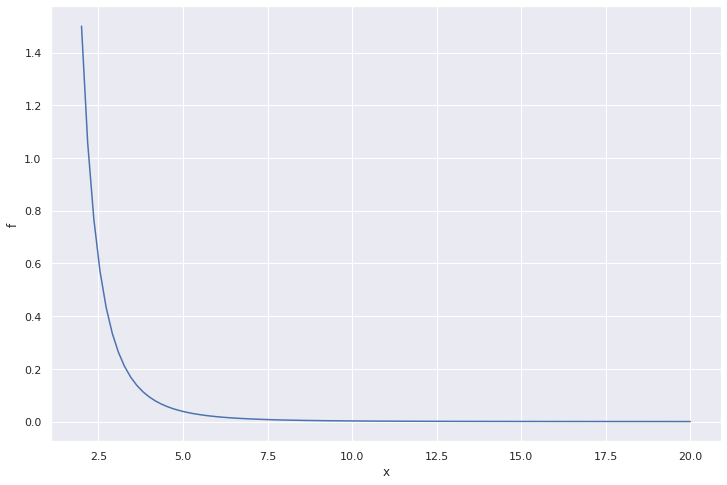

In [21]:
support = np.linspace(dens.L, 20, 100)
density_values = np.vectorize(dens.pdf)(support)

lineplot(support, density_values, ["x", "f"])
plt.show()

### Structural functions and constants

In [6]:
gamma = 0.8
fixed_costs = 10
labour_supply = 20

In [7]:
def production(labour: float, prod_draw: float, gamma=gamma):
    return prod_draw*np.power(labour, gamma)

def marginal_costs(labour, wage):
    return labour*wage

def marginal_prod(labour, *args):
    """
    Computes the first order condition of production at a given labour.
    Forwards all other arguments to production
    """
    return derivative(lambda lab: production(lab, *args), labour)

def profit(
    labour, wage, prod_draw,
    fixed_costs=fixed_costs, **kwargs
    ):
    total_costs = marginal_costs(labour, wage) + fixed_costs
    return production(labour, prod_draw, **kwargs) - total_costs

### Part 1. Optimality on draw and wage

We are going to compute $l(w, s)$, $\pi(w, s)$, that will return the optimal labour and profit given a productivity draw $s$ and a wage $w$. 

In [8]:
positive_bounds = ((0, None),)

@np.vectorize
def optimal_labour(wage, prod_draw):
    result = opt.minimize(
        lambda lab: -profit(lab, wage, prod_draw),
        0, bounds=positive_bounds)
    
    return result.x[0]

def pi(*optimal_labour_args):
    opt_labour = optimal_labour(*optimal_labour_args)
    
    return profit(opt_labour, *optimal_labour_args)

In [9]:
W, S = np.meshgrid(np.linspace(1, 7, 30), np.linspace(1, 20, 30))
Z = optimal_labour(W, S)

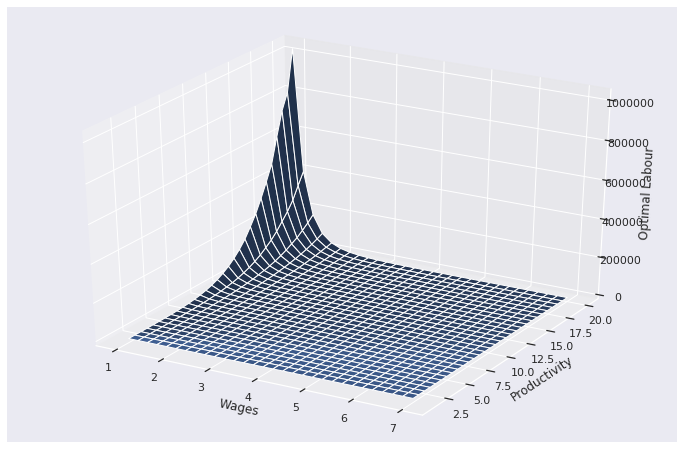

In [10]:
ax = plt_3d(W, S, Z, ["Wages", "Productivity", "Optimal Labour"])
plt.show()

### Part 2. Productivity threshold

Given a fixed cost $c_d$, a firm will hire labour unitil $s_d$, where 

\begin{align}
    s_d: \pi(w, s_d) = 0
\end{align}

In [11]:
@np.vectorize
def threshold_draw(wage, x0=10):
    sd = opt.root(lambda s: pi(wage, s), x0)
    if not sd.success: raise RuntimeError(sd.message)

    return sd.x[0]

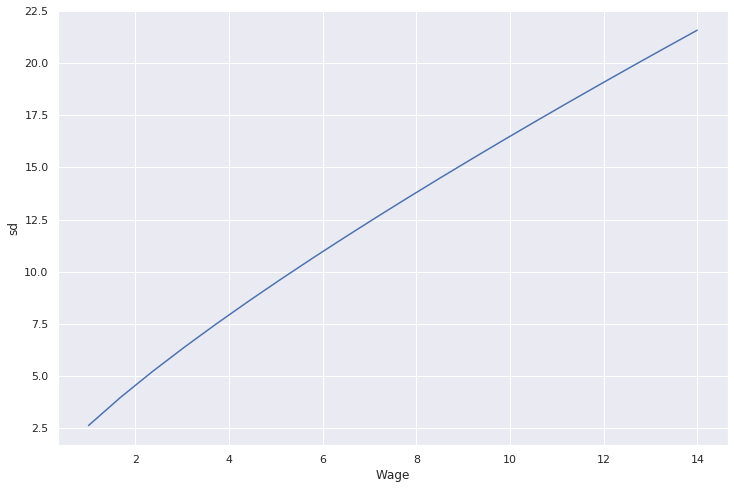

In [12]:
ws = np.linspace(1, 14, 20)
tresholds = threshold_draw(ws)

ax = lineplot(ws, tresholds, ["Wage", "sd"])
plt.show()

### Part 3. 

We first define aggregate labour demand as 

\begin{align}
    L(w, N \vert s_d) = N \cdot \int^{\infty}_{s_d} l(s, w) \cdot dG(a)
\end{align}

where $G$ is the c.d.f. of the Bounded Pareto Distribution

In [13]:
lower_bound = 3
wage = 10
N = 1

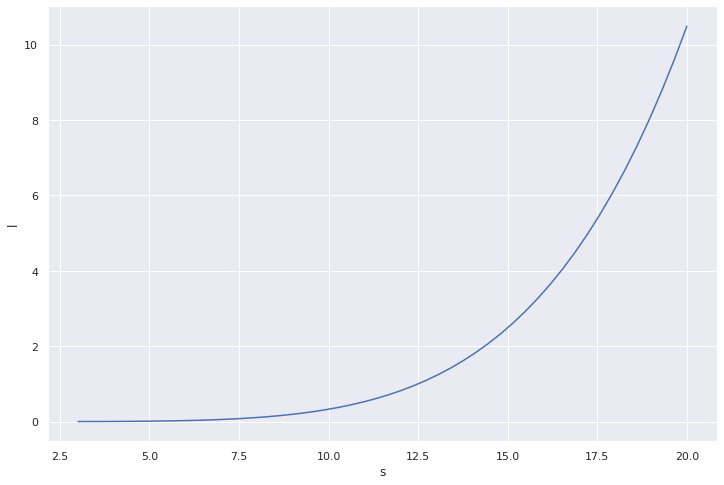

In [14]:
density = BoundedParetoDensity(L=lower_bound)
prod_space = np.linspace(lower_bound +.01, 20)
lab = np.vectorize(lambda s: optimal_labour(wage, s))(prod_space)

ax = lineplot(prod_space, lab, ["s", "l"])
plt.show()

In [15]:
def labour_demand(sd):
    density = BoundedParetoDensity(L=sd)
    
    def aggregate(wage, N):
        return N*density.integrate(lambda s: optimal_labour(wage, s))
    
    return aggregate

/mnt/c/Users/andre/tinbergen/homework/macro_three/utils/distribution.py:48: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  upper
/home/nofishlikeian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


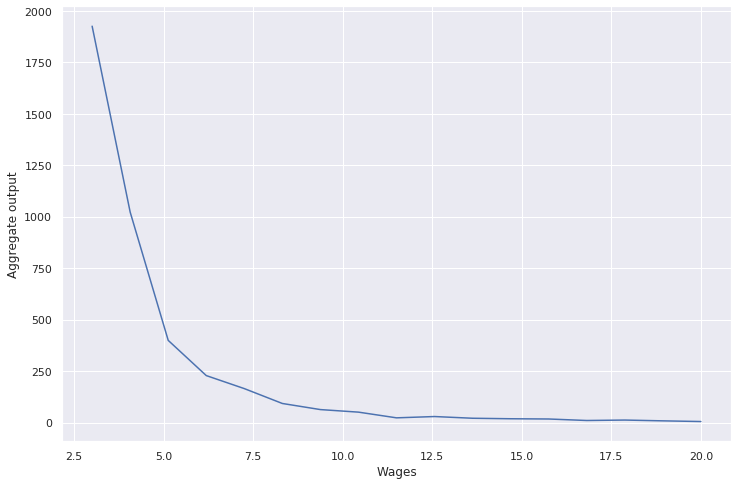

In [19]:
labour_dem_fn = labour_demand(lower_bound)
wage_space = np.linspace(3, 20, 20-3)
output = np.vectorize(lambda w: labour_dem_fn(w, 1))(wage_space)

ax = lineplot(wage_space, output, ["Wages", "Aggregate output"])
plt.show()